# Wikipedia Pageviews Analytics

## Prerequisites (pip install)

In [ ]:
%pip install boto3 pandas matplotlib


## S3 Dataset Analysis

In [ ]:
import boto3
import json
import logging

logger = logging.getLogger()
logger.setLevel(logging.INFO)

session = boto3.Session(profile_name='wikipedia', region_name='us-east-1')

# Then create clients/resources from this session
s3 = session.client('s3')

bucket_name = 'wikipedia-pageviews-dev-198328422183-us-east-1'


In [24]:
s3_list_objects = s3.list_objects(Bucket=bucket_name)

In [58]:
import pandas as pd

pageviews_acc_list = []
count = 0

for pageviews_file in [s3_object['Key'] for s3_object in s3_list_objects['Contents']]:
    print(pageviews_file)
    pageviews_payload = s3.get_object(Bucket=bucket_name, Key=pageviews_file)["Body"].read().decode()
    pageviews = json.loads(pageviews_payload)['items'][0]
    header = {
        'project': 'en.wikipedia', 
        'access': 'all-access', 
        'year': pageviews['year'],
        'month': pageviews['month'],
        'day': pageviews['day']
    }
    logger.info(f"Header: {header}")
    pageviews_df = pd.DataFrame(pageviews['articles'])
    # Add the header to each row of your dataframe
    for column, value in header.items():
        pageviews_df[column] = value
    pageviews_acc_list.append(pageviews_df)
    count += 1
    if count == 10:
        break

pageviews = pd.concat(pageviews_acc_list, ignore_index=True)

data/year=2015/month=07/day=01/pageviews-2015-07-01 00:00:00.json
data/year=2015/month=07/day=02/pageviews-2015-07-02 00:00:00.json
data/year=2015/month=07/day=04/pageviews-2015-07-04 00:00:00.json
data/year=2015/month=07/day=06/pageviews-2015-07-06 00:00:00.json
data/year=2015/month=07/day=08/pageviews-2015-07-08 00:00:00.json
data/year=2015/month=07/day=10/pageviews-2015-07-10 00:00:00.json
data/year=2015/month=07/day=12/pageviews-2015-07-12 00:00:00.json
data/year=2015/month=07/day=14/pageviews-2015-07-14 00:00:00.json
data/year=2015/month=07/day=16/pageviews-2015-07-16 00:00:00.json
data/year=2015/month=07/day=18/pageviews-2015-07-18 00:00:00.json


In [59]:
pageviews

,article,views,rank,project,access,year,month,day
0,Main_Page,20364038,1,en.wikipedia,all-access,2015,07,01
1,Special:Search,2034452,2,en.wikipedia,all-access,2015,07,01
2,Angelsberg,758151,3,en.wikipedia,all-access,2015,07,01
3,User:GoogleAnalitycsRoman/google-api,258566,4,en.wikipedia,all-access,2015,07,01
4,Malware,217855,5,en.wikipedia,all-access,2015,07,01
...,...,...,...,...,...,...,...,...
9994,Alicia_Silverstone,9431,996,en.wikipedia,all-access,2015,07,18
9995,Harrison_Ford,9430,997,en.wikipedia,all-access,2015,07,18
9996,Gal_Gadot,9427,998,en.wikipedia,all-access,2015,07,18
9997,Laura_Prepon,9422,999,en.wikipedia,all-access,2015,07,18


In [87]:
def is_content(article):
    prefixes = ("Wikipedia:", "MediaWiki:", "Template:", "Help:", "Category:", "Portal:", "Draft:", "TimedText:", "Module:", "Special:", "Media:")
    return not (\
        article in ['Main_Page'] \
            or article.startswith(prefixes) \
            or '_talk:' in article
    )

i = 0
for s in pageviews['article']:
    if not is_content(s):
        i += 1
        print(f"{i:<4} - {s:<40}")

#[s for s in pageviews if is_content(s['article'])]

1    - Main_Page                               
2    - Special:Search                          
3    - Special:Book                            
4    - Special:RecentChanges                   
5    - Template:GeoTemplate                    
6    - Special:Watchlist                       
7    - Portal:Current_events                   
8    - Special:CiteThisPage                    
9    - Special:RecentChangesLinked             
10   - Special:MobileMenu                      
11   - Special:ListUsers                       
12   - Help:IPA_for_English                    
13   - Special:BlockList                       
14   - Special:MobileOptions                   
15   - Special:RecentChangesLinked/Lean_Six_Sigma
16   - Wikipedia:Your_first_article            
17   - Special:WhatLinksHere                   
18   - Portal:Contents                         
19   - Special:Log                             
20   - Wikipedia:About                         
21   - Special:NewPagesFeed           

In [ ]:
SPECIAL_PAGES = [
    'Main_Page',
    'Special:Search',]

<Axes: xlabel='article'>

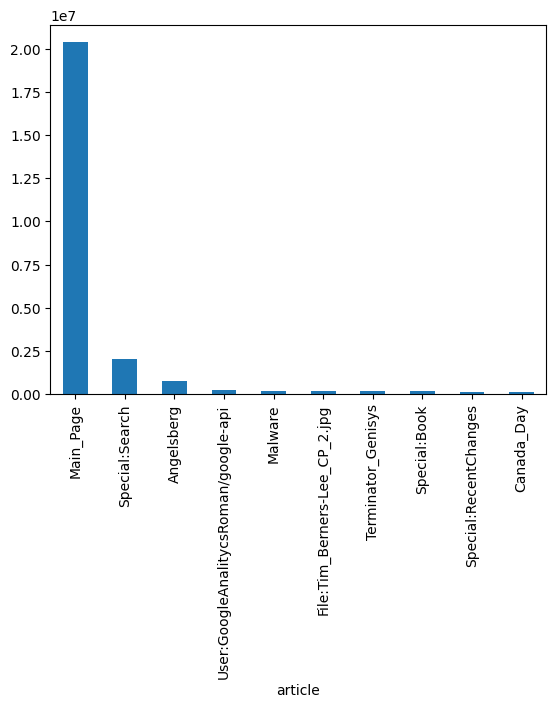

In [67]:
import matplotlib.pyplot as plt
pageviews.iloc[:10][['article', 'views']].plot(kind='bar', x='article', y='views', legend=False)

## Download Pageviews

In [4]:
import datetime

PAGEVIEWS_START_DATE = datetime.datetime(year=2015, month=7, day=1)

def get_pageviews_date_offset(offset: int) -> None:
    ds = PAGEVIEWS_START_DATE + datetime.timedelta(days=offset)
    print(ds.strftime('%Y-%m-%d'))

if __name__ == '__main__':
    for offset in range(0, 10):
        get_pageviews_date_offset(offset)

2015-07-01
2015-07-02
2015-07-03
2015-07-04
2015-07-05
2015-07-06
2015-07-07
2015-07-08
2015-07-09
2015-07-10


In [17]:
import json
import os
import requests
import time

CACHE_ROOT_DIR=f"/tmp"

def cached_download(path: str, url: str) -> bool:
    cache_path = f"{CACHE_ROOT_DIR}/{path}"
    if not os.path.isfile(cache_path):
        print(f"Missed cache. Downloading {url}")
        headers = {
            'User-Agent': 'ralgara@gmail.com'
        }
        time.sleep(0.5)
        req = requests.request("GET", url, headers=headers)
        if req.ok:
            with open(cache_path, 'w') as cache_file:
                cache_file.write(req.text)
            print("Download cached")  
        else:
            print(f'Request failed ({req.status_code}:{req.reason}')
            print(req.text)

    with open(cache_path, 'r') as cache_file:
        print(f"Reading from filesystem: {cache_path}")
        return cache_file.read()
    
def import_pageviews(date) -> str:
    print(f"import_pageviews({date})")
    url_prefix = "https://wikimedia.org/api/rest_v1/metrics/pageviews/top/en.wikipedia/all-access/"
    url = url_prefix + date.replace('-','/')
    path = f"pageviews-{date.replace('-','')}"
    print(f"Downloading {url}")
    s = cached_download(path, url)
    doc = json.loads(s)
    return doc['items'][0]['articles'][:10]

import_pageviews('2025-02-11')

import_pageviews(2025-02-11)
Reading from filesystem: /tmp/pageviews-20250211


[{'article': 'Main_Page', 'views': 5179679, 'rank': 1},
 {'article': 'Special:Search', 'views': 1249142, 'rank': 2},
 {'article': 'Kendrick_Lamar', 'views': 508892, 'rank': 3},
 {'article': 'Gulf_of_Mexico', 'views': 429416, 'rank': 4},
 {'article': 'Belle_Gibson', 'views': 338438, 'rank': 5},
 {'article': 'Drake–Kendrick_Lamar_feud', 'views': 326600, 'rank': 6},
 {'article': 'Gina_Rinehart', 'views': 321785, 'rank': 7},
 {'article': 'Serena_Williams', 'views': 318997, 'rank': 8},
 {'article': 'Wikipedia:Featured_pictures', 'views': 265917, 'rank': 9},
 {'article': 'Not_Like_Us', 'views': 242529, 'rank': 10}]